In [7]:
# needed functions and libraries
import pandas as pd
import seaborn as sns
from pathlib import Path
import signature_functions as sf

# inputs

In [8]:
config_path = '/media/kusterlab/internal_projects/active/TOPAS/WP31/Playground/Retrospective_study/2023.07.03_AhS_PANCANCER_COHORT_batch116/configs.json'
configs = sf.config_reader(config_path)
report_dir = configs['results_folder']
meta_file_path = configs['metadata_annotation']
meta_df = pd.read_excel(meta_file_path)
sf.entity_subtypes = 'code_oncotree'
path_to_file = f'{report_dir}/preprocessed_fp.csv'

# signature by t_test
intensity_file = sf.read_intensity_file(path_to_file,'Gene names')
entity = 'CHDM'

In [75]:
input_df,list_proteins = sf.prepareDataframeforTest(
                                                    intensity_file,
                                                    meta=meta_df,
                                                    minimum_patients_per_entity = 8,
                                                    protein_expressed_in_at_least_percent = 70)

In [9]:


def signature_pipeline(entity):
    # Preprocessing
    

    # univariate Analysis with Cross_validation
    ROC_univariate_df = sf.univariate_analysis_with_CV_for_all_proteins(input_df,
                                                    list_proteins,
                                                    entity,
                                                    K_folds = 5,
                                                    repeats = 5,
                                                    threshold = 0.8
                                                    )

    # T_test
    first_t_test_result_df = sf.one_vs_all_t_test(
                            input_df,
                            list_proteins,
                            entity,
                            sf.entity_subtypes)
    t_test_univariate_df = first_t_test_result_df.merge(ROC_univariate_df,right_on='names',left_on='Gene Names')
    t_test_univariate_df.to_excel(Path(report_dir)/f'FP_signatures_{entity}.xlsx')
    print(f'{entity}_Finished')
    return t_test_univariate_df

In [10]:
signiture_df = signature_pipeline(entity)

/home/amir/topas/mtb/mtb_portal/flask-backend/notebooks/Signatures/signature_functions.py:225: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p_df['up_down'][(p_df['means_group1'] < p_df['means_group2'])] = 'down'


CHDM_Finished


In [12]:
signiture_df['delta'] = abs(signiture_df['means_group1'] -signiture_df['means_group2'])
final_signatures_df = signiture_df[(signiture_df['delta'] > 1) & (signiture_df['CV_robustness_above_0.8'] == 100) & (signiture_df['p_values'] < 0.05)]
final_signatures = final_signatures_df['Gene Names'].tolist()
final_signatures = [x for x in input_df.columns if x in final_signatures]
final_signatures.append('Entities')

input_df['Entities'] = 'Chordoma'
input_df['Entities'][input_df['code_oncotree'] !='CHDM'] = 'None-Chordoma'
input_df = input_df.loc[:,final_signatures]

# visualizations

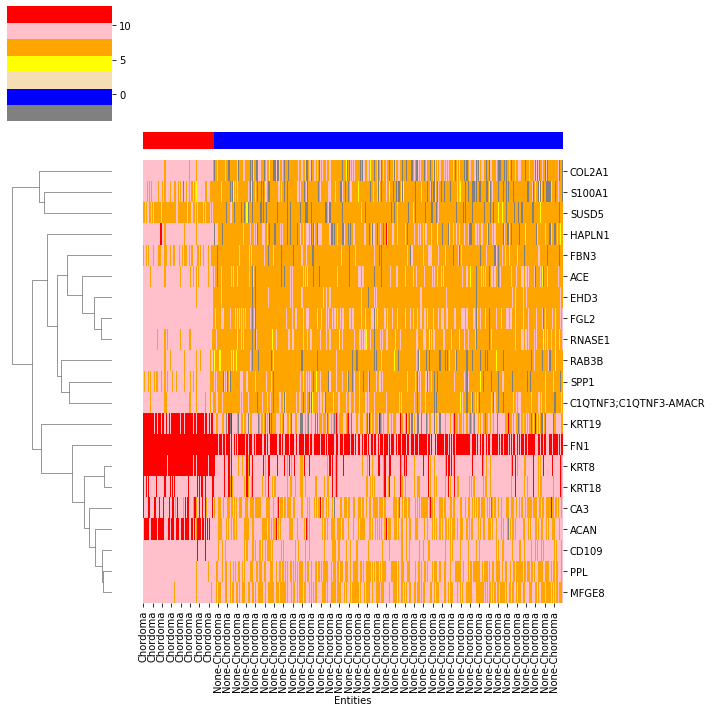

In [82]:

# Clustermap of the triplicates 
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from matplotlib import colors
plt.rcParams["figure.figsize"] = [20, 7]
plt.rcParams["figure.autolayout"] = True


from scipy.cluster.hierarchy import linkage
heat_Data = input_df.sort_values(by=['Entities']).fillna(-4) 
heat_Data = heat_Data.set_index('Entities')

lut = {"Chordoma" : 'red',
       "None-Chordoma" : 'blue'}


cmap = colors.ListedColormap(['grey','blue','wheat','yellow','orange','pink','red'])
bounds = [-4,0,8,9,10,11,12]
norm = colors.BoundaryNorm(bounds,cmap.N)

col_colors = heat_Data.index.map(lut)

link = linkage(heat_Data,method = 'ward',optimal_ordering=False)
sns.clustermap(heat_Data.T,col_linkage=link, method='ward',metric='euclidean',col_colors=col_colors,col_cluster=False, cmap=cmap)
plt.savefig(f'{report_dir}/CHDM_vs_all.svg', dpi=300)

# T_test  + Cross_validaton

/home/amir/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/amir/topas/mtb/mtb_portal/flask-backend/notebooks/Signatures/signature_functions.py:225: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p_df['up_down'][(p_df['means_group1'] < p_df['means_group2'])] = 'down'
/home/amir/topas/mtb/mtb_portal/flask-backend/notebooks/Signatures/signature_functions.py:225: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p_df['up_down'][(p_df['means_group1'] < p_df['means_group2'])

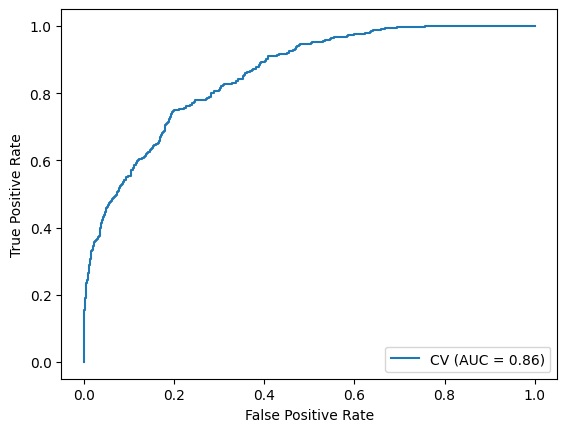

0.855868656716418

In [5]:
CV_reseults = sf.cross_validation_for_one_vs_all_t_test(
                                        input_df,
                                        intensity_file,
                                        meta_df,
                                        entity,
                                        list_proteins,
                                        k_folds = 5,
                                        num_repeats = 5,
                                        p_value_cutoff = None,
                                        fdr_cutoff = .01,
                                        average_difference_twogroups = .5) 
sf.ROC_curve_analysis(CV_reseults.labels,CV_reseults.scores,curve_title='CV')

# SVM + Cross_validation

/home/amir/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/amir/topas/mtb/mtb_portal/flask-backend/notebooks/Signatures/signature_functions.py:225: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p_df['up_down'][(p_df['means_group1'] < p_df['means_group2'])] = 'down'
/home/amir/topas/mtb/mtb_portal/flask-backend/notebooks/Signatures/signature_functions.py:225: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p_df['up_down'][(p_df['means_group1'] < p_df['means_group2'])

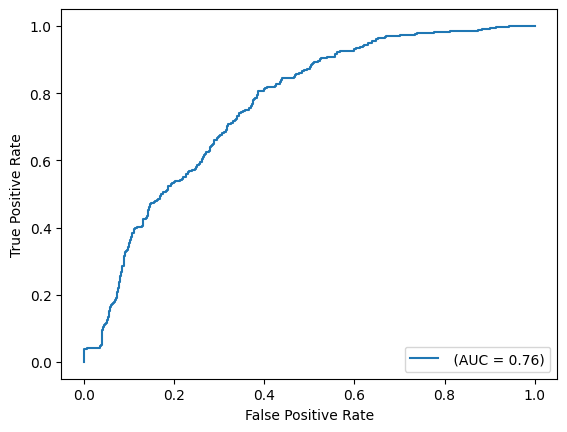

In [6]:
SVM_resutls =  sf.SVM_cross_validaition_with_t_test_Feature_selection(input_df,
                                                        intensity_file,
                                                        meta_df,
                                                        list_proteins,
                                                        Entity = entity,
                                                        p_value_cutoff = None,
                                                        fdr_cutoff = .01,  # for t_test as the feature selecetor
                                                        average_difference_twogroups = .5,  # the difference between the two groups
                                                        n_splits = 5,
                                                        n_repeats = 5,
                                                        weight_multiplier = -1
                                                        )